Настройка числа кластеров в алгоритме K-Means. Elbow и Silhouette метод.


Цель: Используя данный датасет https://archive.ics.uci.edu/ml/datasets/Wholesale+customers произвести кластеризацию методом k-means. 

Проверить оптимальное число k с применением silhouette score методом локтя(elbow).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


from sklearn.preprocessing import StandardScaler

import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('Wholesale customers data.csv')
data


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [3]:
data.info();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
# Все признаки целочисленные без пропусков


In [5]:
data.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [6]:
data.isnull().sum()


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

# Признаки

In [7]:
data['Channel'].value_counts()


1    298
2    142
Name: Channel, dtype: int64

In [8]:
features = data.columns.tolist()
features.remove('Channel')
features


['Region',
 'Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicassen']

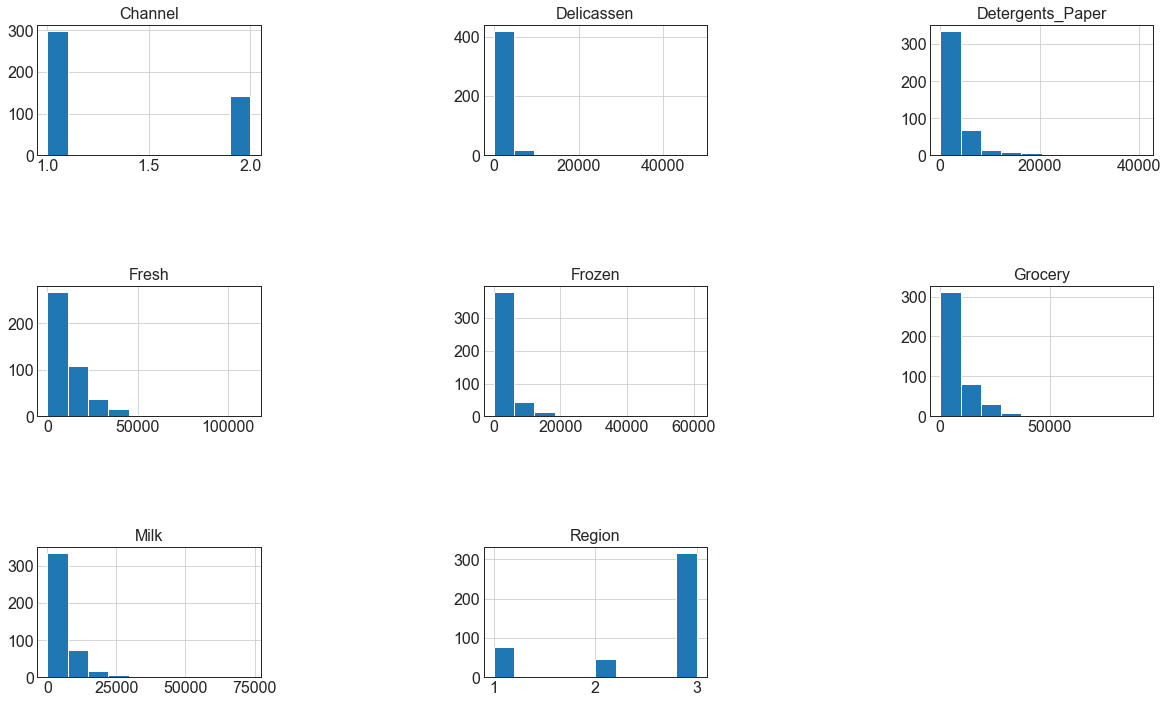

In [58]:
data.hist(figsize = (20, 12), bins = 10);
plt.subplots_adjust(wspace = 1, hspace = 1);


In [10]:
data['Region'].value_counts()


3    316
1     77
2     47
Name: Region, dtype: int64

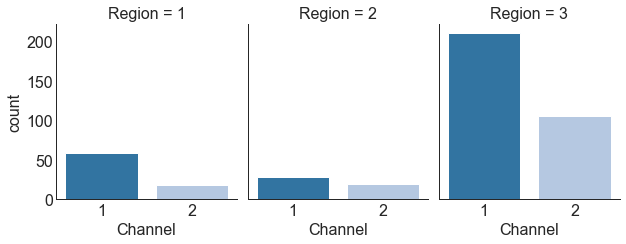

In [11]:
g = sns.catplot("Channel", col = 'Region', col_wrap = 4,
                data = data,
                kind = "count", height = 3.5, aspect = .8, 
                palette = 'tab20')

plt.show()


CPU times: user 5.32 s, sys: 48.5 ms, total: 5.37 s
Wall time: 5.38 s


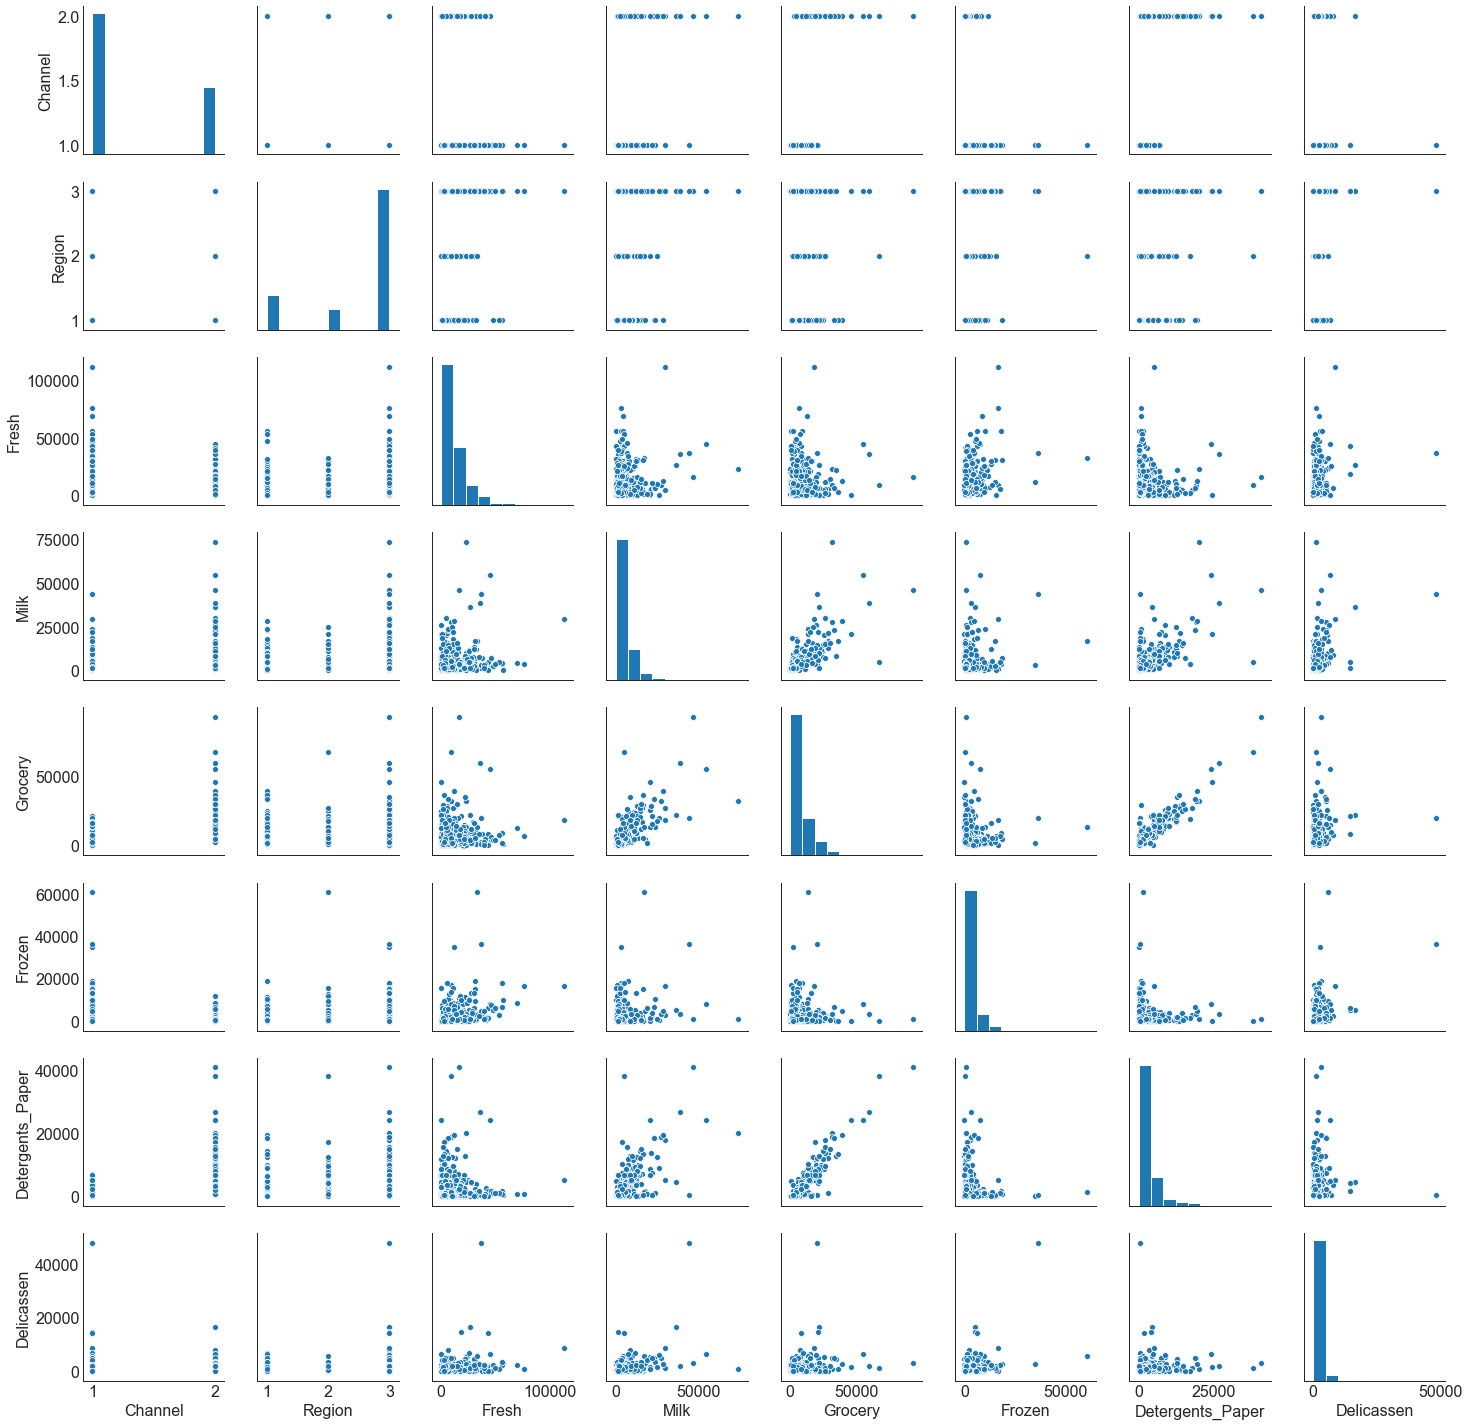

In [12]:
%%time
sns.pairplot(data);


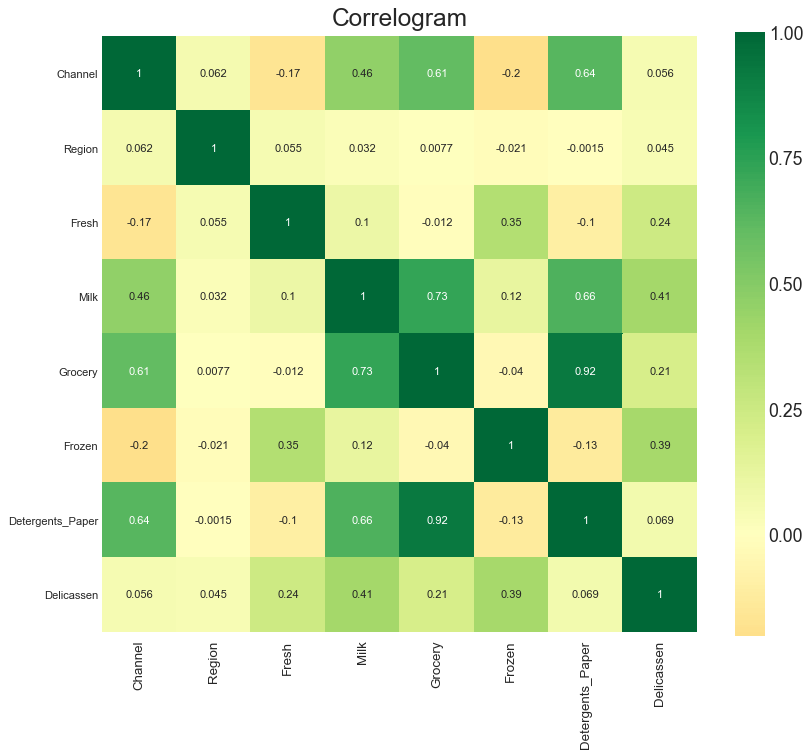

In [13]:
Corr = data.corr()

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(Corr, xticklabels = Corr.columns, yticklabels = Corr.columns, cmap = 'RdYlGn',
            center = 0, annot = True)

plt.title('Correlogram', fontsize = 22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.axis('equal')
plt.show()


In [14]:
CorField = []
CorPairs = []
CorrDel = []

for i in Corr:
    for j in Corr.index[Corr[i] > 0.80]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            CorPairs.append([i, j, Corr[i][Corr.index == j].values[0]])
            CorrDel.append(i)
            print (i, '-->', j, ': R =', Corr[i][Corr.index == j].values[0])


Grocery --> Detergents_Paper : R = 0.9246406908542681


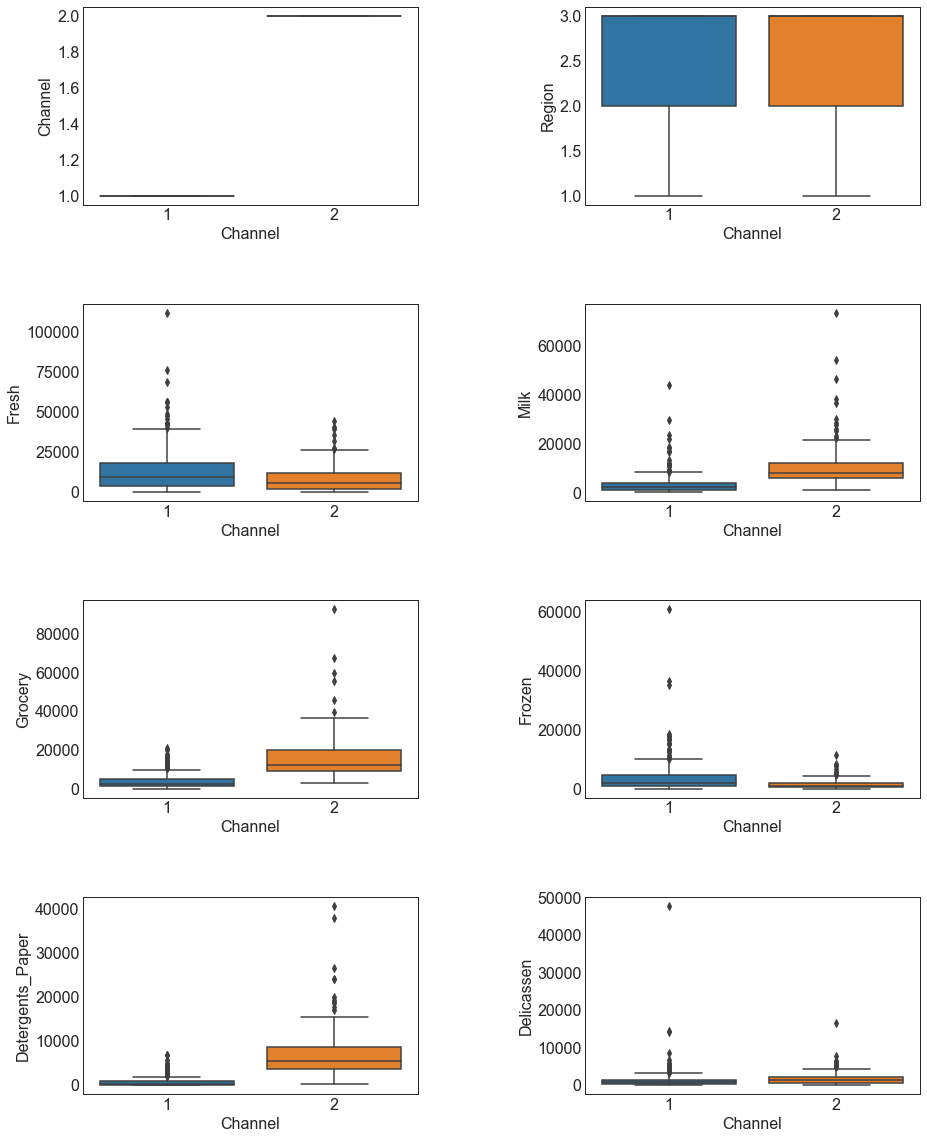

In [15]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 20))

for idx, feat in enumerate(Corr):
    sns.boxplot(x = 'Channel', y = feat, data = data, ax = axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_xlabel('Channel')
    axes[idx // 2, idx % 2].set_ylabel(feat);
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)


In [16]:
data.pivot_table(features, ['Channel'], aggfunc='mean')


,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk,Region
Channel,,,,,,,
1,1415.956376,790.560403,13475.560403,3748.251678,3962.137584,3451.724832,2.510067
2,1753.436620,7269.507042,8904.323944,1652.612676,16322.852113,10716.500000,2.612676


In [17]:
data.pivot_table(features, ['Channel'], aggfunc='median')


,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk,Region
Channel,,,,,,,
1,821,385.5,9581.5,2057.5,2684,2157,3
2,1350,5614.5,5993.5,1081.0,12390,7812,3


In [18]:
# У некоторых признаков среднее значение и медиана у разных классов значительно отличаются


In [19]:
# Особенно выделяются признаки "Detergents_Paper" и "Grocery", причем их корреляция с Channel более 0.50:
print(data['Channel'].corr(data['Detergents_Paper']), data['Channel'].corr(data['Grocery']))


0.6360263670705519 0.6087922451911315


In [22]:
# А между собой имеют очень высокую корреляцию:
print(data['Detergents_Paper'].corr(data['Grocery']))


0.9246406908542679


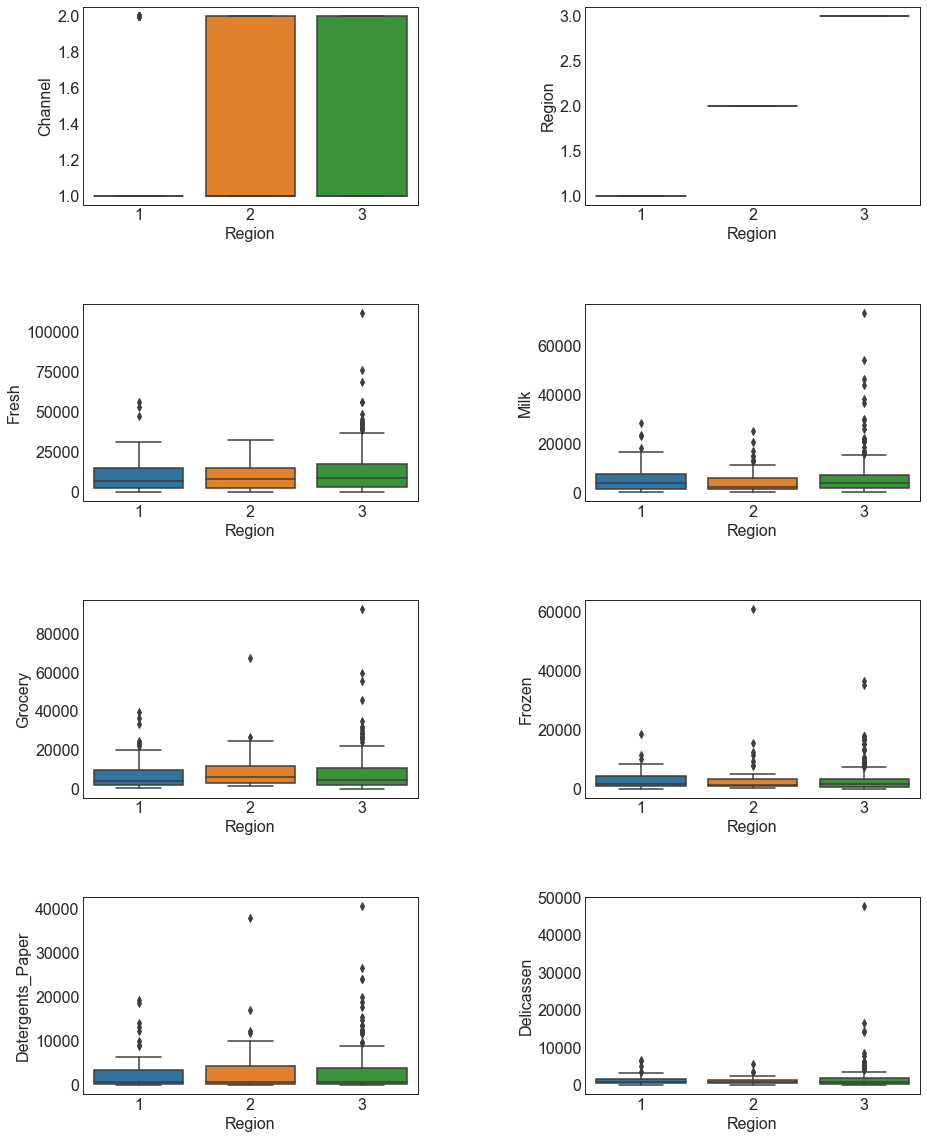

In [36]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 20))

for idx, feat in enumerate(Corr):
    sns.boxplot(x = 'Region', y = feat, data = data, ax = axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_xlabel('Region')
    axes[idx // 2, idx % 2].set_ylabel(feat);
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)


# ML

In [23]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn import metrics


## KMeans

[0.5115333882980367, 0.4764089086483815, 0.3866313675434283, 0.3883666583603302, 0.38845960510975125, 0.35134983219944965, 0.3275283274882426, 0.31094283689251445, 0.3127773495465865, 0.2945598992283693, 0.29374250719196293, 0.29587802985260186, 0.2985387190265329, 0.28317023009936937, 0.3027287205103959, 0.27911383928565126, 0.26941352455962325, 0.26890754893911395]


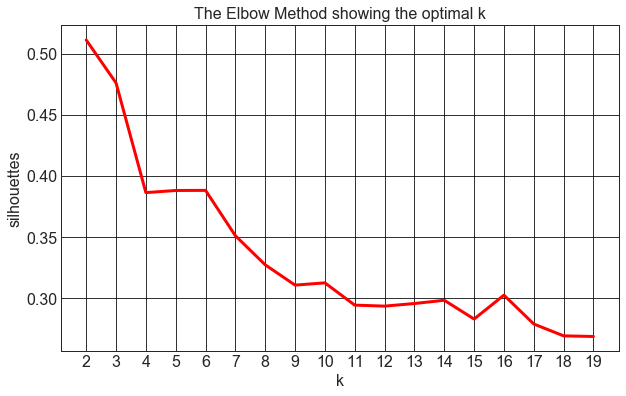

In [59]:
# Посмотрим на Силуэт

silhouettes = []
k = range(2, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(data)
    silhouettes.append(silhouette_score(data, km.labels_))

print(silhouettes)
    
fig, ax = plt.subplots()
ax.plot(k, silhouettes, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.grid(which='major', color = 'k')

fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('silhouettes')
plt.title('The Elbow Method showing the optimal k');
plt.show();


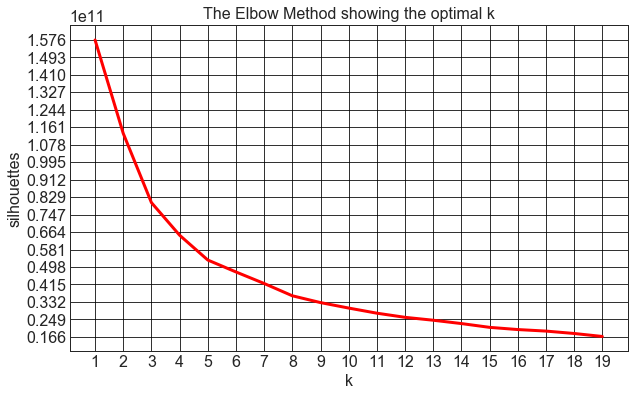

In [27]:
# Посмотрим на Инерцию:
inertia = []
k = range(1, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(data)
    inertia.append(km.inertia_)

m = int(max(inertia) / len(k))

fig, ax = plt.subplots()
ax.plot(k, inertia, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(m))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('silhouettes')
plt.title('The Elbow Method showing the optimal k');
plt.show();


In [62]:
# По методу "Локтя" оптимальным выглядит число кластеров равное 2.
# Если смотреть на Инерцию, то тут все не так однозначно, линия слишком пологая. И 'перелом', наверно, где-то в районе k=5


In [60]:
km = KMeans(n_clusters = 2).fit(data)
km.cluster_centers_


array([[1.21538462e+00, 2.63076923e+00, 3.54013692e+04, 9.51423077e+03,
        1.03463692e+04, 6.46309231e+03, 2.93304615e+03, 3.31684615e+03],
       [1.34133333e+00, 2.52800000e+00, 7.94411200e+03, 5.15181867e+03,
        7.53612800e+03, 2.48413067e+03, 2.87255733e+03, 1.21426133e+03]])

In [61]:
len(km.labels_)


440

### Посмотрим, что изменится при скалировании данных:

In [30]:
data_scaler = StandardScaler().fit_transform(data)
data_scaler


array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

[0.37323636511581165, 0.3598428112363612, 0.3643048480376128, 0.3507517883607992, 0.35372758942528437, 0.36383187239176745, 0.3629584525643706, 0.31869106281340287, 0.3652933243211767, 0.3345472030116207, 0.3330957529388998, 0.33634473355752575, 0.3389075387319199, 0.32310280148721815, 0.2276435092824685, 0.3140097043074425, 0.2214717946850416, 0.2320790251243364]


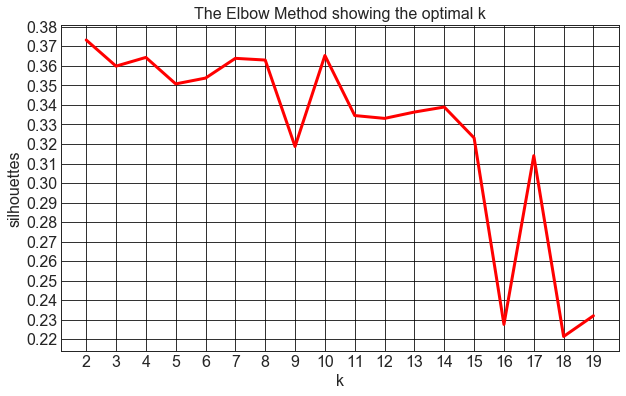

In [64]:
# Силуэт
silhouettes = []
k = range(2, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(data_scaler)
    silhouettes.append(silhouette_score(data_scaler, km.labels_))

print(silhouettes)

fig, ax = plt.subplots()
ax.plot(k, silhouettes, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('silhouettes')
plt.title('The Elbow Method showing the optimal k');
plt.show();


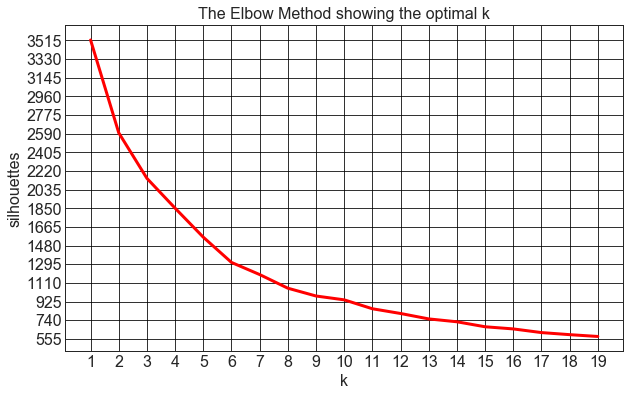

In [33]:
# Инерция:
inertia = []
k = range(1, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(data_scaler)
    inertia.append(km.inertia_)

m = int(max(inertia) / len(k))

fig, ax = plt.subplots()
ax.plot(k, inertia, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(m))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('K-means score')
plt.title('The Elbow Method showing the optimal k');
plt.show();


In [65]:
# Для скалированных данных, silhouettes при k=2 не так сильно выделяется, как ранее.
# При некоторых запусках при k = 8, 10 значения silhouettes бывали максимальными.
# Предполагаю это сязано с плотностью данных - при скалировании данные 'уплотнились'.


### Попробуем удалить из данных коррелирующий признак


In [38]:
df = data.drop(CorrDel, axis = 1)
df

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,214,2674,1338
1,2,3,7057,9810,1762,3293,1776
2,2,3,6353,8808,2405,3516,7844
3,1,3,13265,1196,6404,507,1788
4,2,3,22615,5410,3915,1777,5185
...,...,...,...,...,...,...,...
435,1,3,29703,12051,13135,182,2204
436,1,3,39228,1431,4510,93,2346
437,2,3,14531,15488,437,14841,1867
438,1,3,10290,1981,1038,168,2125


[0.5598873446752224, 0.35205502263277916, 0.40991445645757213, 0.37835135693120686, 0.3707589475869301, 0.3738315494655694, 0.3066188983620922, 0.3038613741209319, 0.3052059255286819, 0.2742035211104281, 0.2760087163650161, 0.2858491718767438, 0.28178751990072665, 0.2865483642750145, 0.28253694520113365, 0.2880244579780699, 0.2944538988179238, 0.2989540900788467]


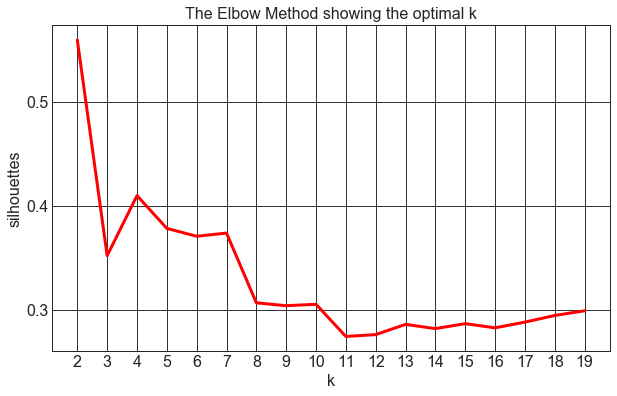

In [44]:
# Силуэт
silhouettes = []
k = range(2, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(df)
    silhouettes.append(silhouette_score(df, km.labels_))

print(silhouettes)

fig, ax = plt.subplots()
ax.plot(k, silhouettes, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('silhouettes')
plt.title('The Elbow Method showing the optimal k');
plt.show();


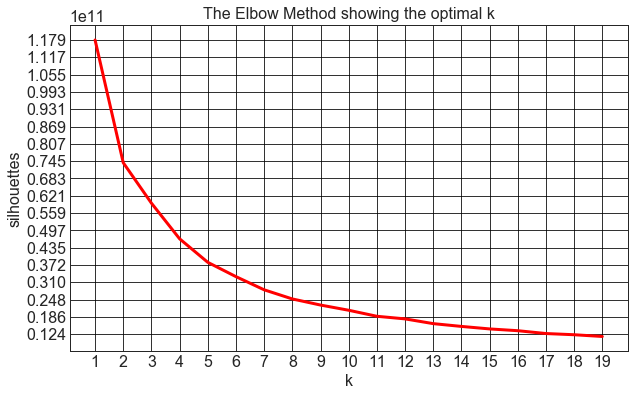

In [42]:
# Инерция:
inertia = []
k = range(1, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(df)
    inertia.append(km.inertia_)

m = int(max(inertia) / len(k))

fig, ax = plt.subplots()
ax.plot(k, inertia, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(m))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('K-means score')
plt.title('The Elbow Method showing the optimal k');
plt.show();


In [45]:
# Картина сильно не изменилась, 
# Единственное, значения silhouettes при k=3 стало значительно меньше чем при k=2.
# До удаления коррелирующего признака (т.е. на полных данных) разность была не такой большой.


### Попробуем удалить двоичный признак "Channel"


In [46]:
df_2 = data.drop('Channel', axis = 1)
df_2


,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3,12669,9656,7561,214,2674,1338
1,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
3,3,13265,1196,4221,6404,507,1788
4,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...
435,3,29703,12051,16027,13135,182,2204
436,3,39228,1431,764,4510,93,2346
437,3,14531,15488,30243,437,14841,1867
438,3,10290,1981,2232,1038,168,2125


[0.5115333886055933, 0.478351141462508, 0.3866313676375216, 0.37043492743551876, 0.38499266328571624, 0.3759413865483073, 0.361585754360298, 0.31191009731571456, 0.3151677767256966, 0.30187113359386303, 0.2645541911704031, 0.2937765089796952, 0.259034807086407, 0.26402071593433507, 0.2721576571751711, 0.26040846880310786, 0.2678408071435579, 0.27366061486519694]


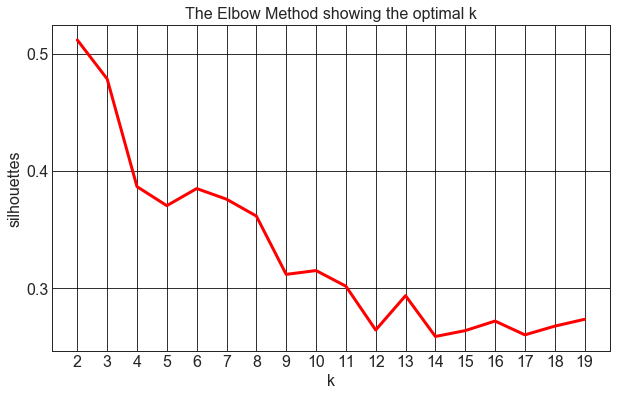

In [47]:
# Силуэт
silhouettes = []
k = range(2, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(df_2)
    silhouettes.append(silhouette_score(df_2, km.labels_))

print(silhouettes)

fig, ax = plt.subplots()
ax.plot(k, silhouettes, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('silhouettes')
plt.title('The Elbow Method showing the optimal k');
plt.show();


In [49]:
# Значение silhouettes все равно 'указывает' на k = 2.

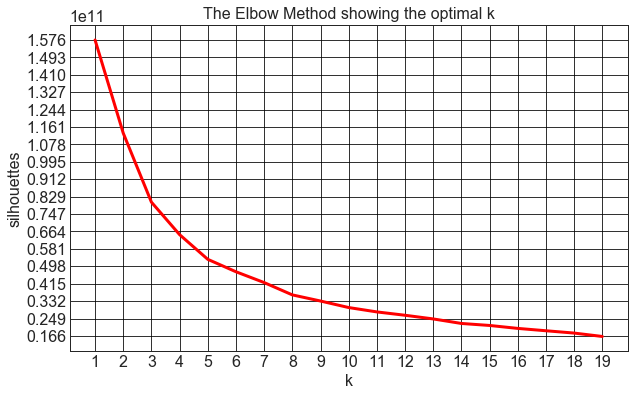

In [48]:
# Инерция:
inertia = []
k = range(1, 20)
for k_i in k:
    km = KMeans(n_clusters = k_i)
    km.fit(df_2)
    inertia.append(km.inertia_)

m = int(max(inertia) / len(k))

fig, ax = plt.subplots()
ax.plot(k, inertia, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(m))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('K-means score')
plt.title('The Elbow Method showing the optimal k');
plt.show();


## MiniBatchKMeans

[0.40453398579566935, 0.4481415762591038, 0.3939828346393381, 0.39017120220889334, 0.37499891226746446, 0.3576113983334193, 0.27902593353980293, 0.31487861319891497, 0.30133019401376904, 0.2807010258713322, 0.2733323074069802, 0.25062221460203793, 0.2675586728199373, 0.24190026682457605, 0.2254275646733803, 0.2548135032552363, 0.179198749930696, 0.2567652831397042]


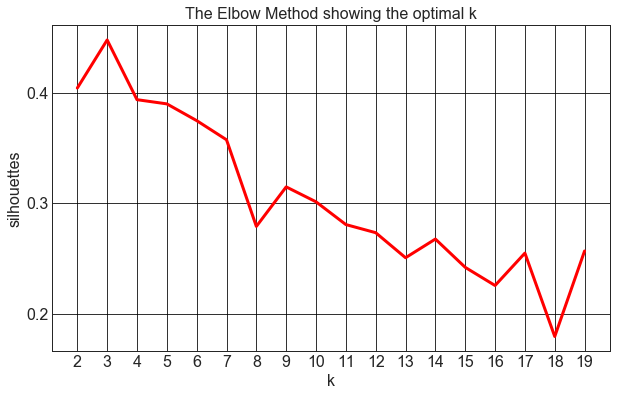

In [53]:
silhouettes = []
k = range(2, 20)
for k_i in k:
    km = MiniBatchKMeans(n_clusters = k_i)
    km.fit(data)
    silhouettes.append(silhouette_score(data, km.labels_))

print(silhouettes)
    
fig, ax = plt.subplots()
ax.plot(k, silhouettes, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('silhouettes')
plt.title('The Elbow Method showing the optimal k');
plt.show();


In [54]:
# При разных запусках значение silhouettes бывает максимальным как при k=2, так и k=3


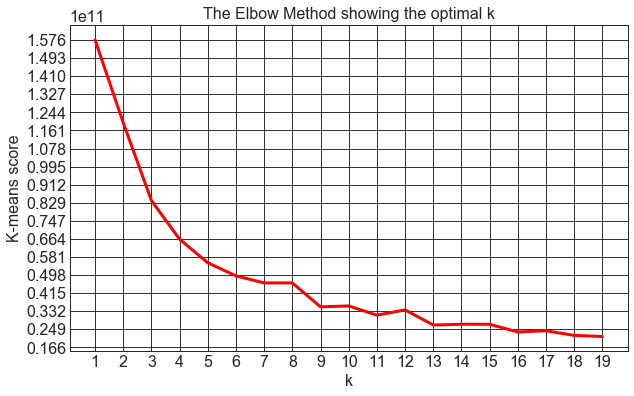

In [57]:
inertia = []
k = range(1, 20)
for k_i in k:
    km = MiniBatchKMeans(n_clusters = k_i)
    km.fit(data)
    inertia.append(km.inertia_)

fig, ax = plt.subplots()
ax.plot(k, inertia, color = 'r', linewidth = 3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(m))
ax.grid(which='major', color = 'k')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.xlabel('k')
plt.ylabel('K-means score')
plt.title('The Elbow Method showing the optimal k');
plt.show();


# Выводы

1. Метод локтя на графике Инерций менее информативен и порой сложно определить значение k, где происходит 'перелом'.
2. Подбор k по silhouettes проще: все таки выбрать наибольшее значение проще, чем найти перелом)
3. Скалирование данных усложнило задачу из-за уплотнения данных. Наверно, это было и так очевидно)
4. При удаление коррелирующего признака пик значений silhouettes стал более выраженным.
5. MiniBatchKMeans при расчете silhouettes добавил вариантов выбора k. Теперь в зависимости от запуска silhouettes бывает бОльшим и при k=2 и при k=3.
6. Алгоритм K-means может давать разные результаты в зависимости от запуска. Это связано с произвольным выбором начальных центров кластеров.
